In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from tensorflow import keras

In [2]:
plt.style.use('ggplot')

In [3]:
seed = 13

## Single Layer Network on the Hitters Data

In [4]:
df_hit = pd.read_csv('../data/hitters.csv')
df_gitter = df_hit.dropna()

In [5]:
df_gitter.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


In [6]:
df_gitter.shape

(263, 20)

In [7]:
test_id = df_gitter.sample(frac=0.33, random_state=seed).index
train_id_bool = ~df_gitter.index.isin(test_id)
gitter_train, gitter_test = df_gitter.loc[train_id_bool, :], df_gitter.loc[test_id, :]

### Linear Regression

In [8]:
# https://stackoverflow.com/questions/35518477/statsmodels-short-way-of-writing-formula
def formula_from_cols(df: pd.DataFrame, y: str) -> str:
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [9]:
gitter_formula = formula_from_cols(df_gitter, 'Salary')
print(gitter_formula)

Salary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists + Errors + NewLeague


In [10]:
l_fit = smf.ols(gitter_formula, data=gitter_train).fit()
l_pred = l_fit.predict(gitter_test).values
lm_gitter_mae = np.mean(np.abs(l_pred - gitter_test.Salary.values))
print(lm_gitter_mae)

242.99282793560906


### Lasso Regression

In [11]:
def get_x_y_gitter(df: pd.DataFrame) -> Tuple:
    gitter_obj_col = list(df_gitter.select_dtypes('object').columns)
    x = pd.get_dummies(df, columns = gitter_obj_col, drop_first=True)\
             .drop('Salary', axis=1)
    y = df['Salary']
    return x, y

In [12]:
gitter_train_x, gitter_train_y = get_x_y_gitter(gitter_train)
gitter_test_x, gitter_test_y = get_x_y_gitter(gitter_test)

In [13]:
def scale_to_df(df: pd.DataFrame, 
                std_scale: StandardScaler) -> pd.DataFrame:
    return pd.DataFrame(std_scale.transform(df), columns = list(df.columns))

In [14]:
std_scale = StandardScaler()
_ = std_scale.fit(gitter_train_x)
gitter_train_x_scaled = scale_to_df(gitter_train_x, std_scale)
gitter_test_x_scaled = scale_to_df(gitter_test_x, std_scale)

In [15]:
cv_fit = LassoCV(cv=5, random_state=seed).fit(gitter_train_x_scaled, 
                                              gitter_train_y)

In [16]:
c_pred = cv_fit.predict(gitter_test_x_scaled)
np.mean(np.abs(gitter_test_y - c_pred))

223.45749081018576

### Neural Network

In [17]:
mod_nn = keras.models.Sequential([
    keras.Input(shape=(gitter_train_x_scaled.shape[1],)),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(1)
]
)

opt = keras.optimizers.RMSprop()
mod_nn.compile(loss='mse',
               optimizer=opt,
               metrics=['mean_absolute_error'])

mod_nn.fit(gitter_train_x_scaled, gitter_train_y, epochs=1500,
           batch_size=32, validation_data=(gitter_test_x_scaled, gitter_test_y), 
           verbose=0)


2021-08-24 13:35:41.783435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-24 13:35:41.853787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [18]:
def plot_history(history_dict: dict, metrics_name: str) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    df_history = pd.DataFrame(history_dict)

    for i, name in zip(range(2), [metrics_name, 'loss']):
        axes[i].plot(df_history[name], label='train')
        axes[i].plot(df_history[f'val_{name}'], label='validation')
        axes[i].set_ylabel(name)
        axes[i].legend()

    plt.show()

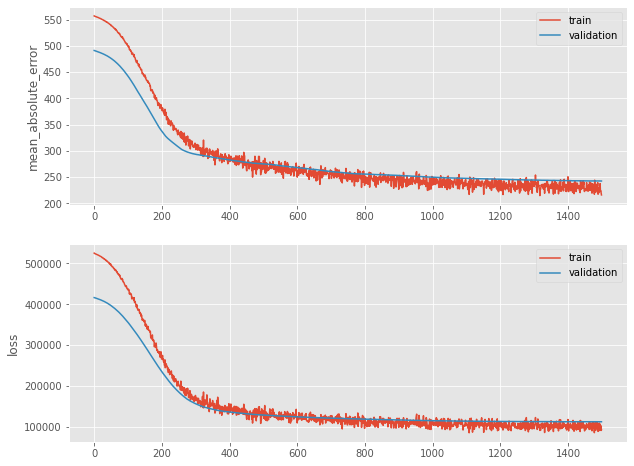

In [19]:
plot_history(mod_nn.history.history, 'mean_absolute_error')

In [20]:
n_pred = mod_nn.predict(gitter_test_x_scaled).reshape(-1)
np.mean(np.abs(gitter_test_y - n_pred))

242.716228941468